In [1]:
%%capture
!pip install torch torchvision

In [2]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader

In [7]:
# Set random seed
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

# Usual transformations
transform_load = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Data augmentation
transform_augmented = transforms.Compose([
        transforms.RandomResizedCrop(size=224 ,scale=(0.2, 1.0), ratio=(0.75, 1.25)),
        transforms.RandomHorizontalFlip(0.5),
        transforms.ColorJitter(brightness=0.9, contrast=0.9,
                                  saturation=0.9, hue=0.1),
        transforms.GaussianBlur(3)
    ])

# Specify the classes you want to keep
selected_classes = [3, 5]

# Get the subset dataset and calculate the mean and std
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_load)
# Get the indices of samples belonging to the selected classes
subset_indices = [i for i in range(len(train_dataset)) if train_dataset.targets[i] in selected_classes]
subset_dataset = torch.utils.data.Subset(train_dataset, subset_indices)

Files already downloaded and verified
10000
Files already downloaded and verified


In [8]:
# Data augmentation
def get_transforms(means, stds):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(means, stds),
    ])
    return transform

# Calculate the mean and std of the subset dataset
def get_mean_std(dataset):
    """Compute the mean and std value of dataset."""
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=2)
    mean = torch.zeros(3)
    std = torch.zeros(3)
    print('==> Computing mean and std..')
    for inputs, targets in dataloader:
        for i in range(3):
            mean[i] += inputs[:, i, :, :].mean()
            std[i] += inputs[:, i, :, :].std()
    mean.div_(len(dataset))
    std.div_(len(dataset))
    return mean, std

In [9]:
# Calculate the mean and std of the subset dataset
train_means, train_stds = get_mean_std(subset_dataset)
print(f'Means: {train_means}')
print(f'Standard deviations: {train_stds}\n')

==> Computing mean and std..
Means: tensor([0.4977, 0.4605, 0.4160])
Standard deviations: tensor([0.2046, 0.2012, 0.2012])


In [10]:
%%capture
# Apply transformations
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=get_transforms(train_means,train_stds))
subset_dataset = torch.utils.data.Subset(train_dataset, subset_indices)

# Data Loader
train_loader = DataLoader(subset_dataset, batch_size=8, shuffle=True, num_workers=2)

In [12]:
# Import necessary libraries
import torch.nn as nn
from torch.nn.functional import cosine_similarity
import torchvision.transforms.functional as TF
import torch.optim as optim
from tqdm import tqdm

class ContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.1):
        super(ContrastiveLoss, self).__init__()
        self.temperature = temperature

    def forward(self, z1, z2, z_list):
        # Calculate cosine similarity
        similarity_pair = cosine_similarity(z1, z2, dim=-1) / self.temperature

        # Calculate the cosine similarity for each pair of z1 and... but not z1 and z1
        similarities = torch.stack([cosine_similarity(z1, rep, dim=-1) / self.temperature for rep in z_list if not torch.equal(rep, z1)])
        
        if similarities.numel() == 0:
            return torch.tensor(0.0, device=z1.device, requires_grad=True)
        
        # Numerator is exp(similarity_pair)
        exp_similarity = torch.exp(similarity_pair)

        # Denominator is sum(exp(list_similarity_pair))
        exp_similarities = torch.sum(torch.exp(similarities))

        # Apply log-sum-exp trick
        loss = -torch.log(exp_similarity / (exp_similarities + exp_similarity))
        
        if torch.isnan(loss):
            return torch.tensor(0.0, device=z1.device, requires_grad=True)
            
        return torch.mean(loss)  # Compute the mean of the loss
    
# Define the Siamese network
class SiameseNetwork(nn.Module):
    def __init__(self, base_model):
        super(SiameseNetwork, self).__init__()
        self.base_model = base_model


    def forward(self, x1, x2):
        z1 = self.base_model(x1)
        z2 = self.base_model(x2)
        return z1, z2
    
# Define a simple ResNet18-based model
class SimpleResNet(nn.Module):
    def __init__(self):
        super(SimpleResNet, self).__init__()
        self.resnet = torchvision.models.resnet18()
        self.resnet.fc = nn.Identity()

    def forward(self, x):
        return self.resnet(x)

In [17]:
# Initialize the model, optimizer, and contrastive loss
model = SiameseNetwork(SimpleResNet())
optimizer = optim.Adam(model.parameters(), lr=10)
criterion = ContrastiveLoss()

In [18]:
%%capture
# Training parameters
num_epochs = 6
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

In [19]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for i, data in enumerate(tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}')):

        images, _ = data
        images = images.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Initialize total loss for the batch
        batch_loss = torch.tensor(0.0, device=device, requires_grad=True)

        # Create tuples of transformed images for each image of the batch and put all the zk, zk+1 in a list (feed forward network)
        zk_list = []
        for image in images:
            transformed_image1 = transform_augmented(image).to(device)
            transformed_image2 = transform_augmented(image).to(device)

            z1, z2 = model(transformed_image1.unsqueeze(0), transformed_image2.unsqueeze(0))
            zk_list.append(z1)
            zk_list.append(z2)
            

        # Process each image in the batch
        for i in range(0, len(zk_list), 2):
            # Calculate loss for both the first transformed image and second
            loss1 = criterion(zk_list[i], zk_list[i+1], zk_list)
            loss2 = criterion(zk_list[i+1], zk_list[i], zk_list)
            batch_loss = batch_loss + (loss1 + loss2)
        
        # Backward pass
        batch_loss.backward()

        # Update weights after processing the entire batch
        optimizer.step()

        total_loss += batch_loss.item() / len(images)

    average_loss = total_loss / len(train_loader)

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss}')
    # if epoch % 10 == 0:
    #     torch.save(model.base_model.state_dict(), f'models/model_weights_epoch_{epoch + 1}.pth')

print('Training finished.')

Epoch 1/6: 100%|██████████| 1250/1250 [04:34<00:00,  4.56it/s]


Epoch 1/6, Loss: 4.028145767974854


Epoch 2/6: 100%|██████████| 1250/1250 [04:37<00:00,  4.51it/s]


Epoch 2/6, Loss: 3.5448168301582337


Epoch 3/6: 100%|██████████| 1250/1250 [04:51<00:00,  4.29it/s]


Epoch 3/6, Loss: 3.1889114938735963


Epoch 4/6: 100%|██████████| 1250/1250 [04:56<00:00,  4.22it/s]


Epoch 4/6, Loss: 3.0145325674057006


Epoch 5/6: 100%|██████████| 1250/1250 [04:47<00:00,  4.34it/s]


Epoch 5/6, Loss: 2.8917261973381043


Epoch 6/6: 100%|██████████| 1250/1250 [04:40<00:00,  4.45it/s]

Epoch 6/6, Loss: 2.879564280509949
Training finished.


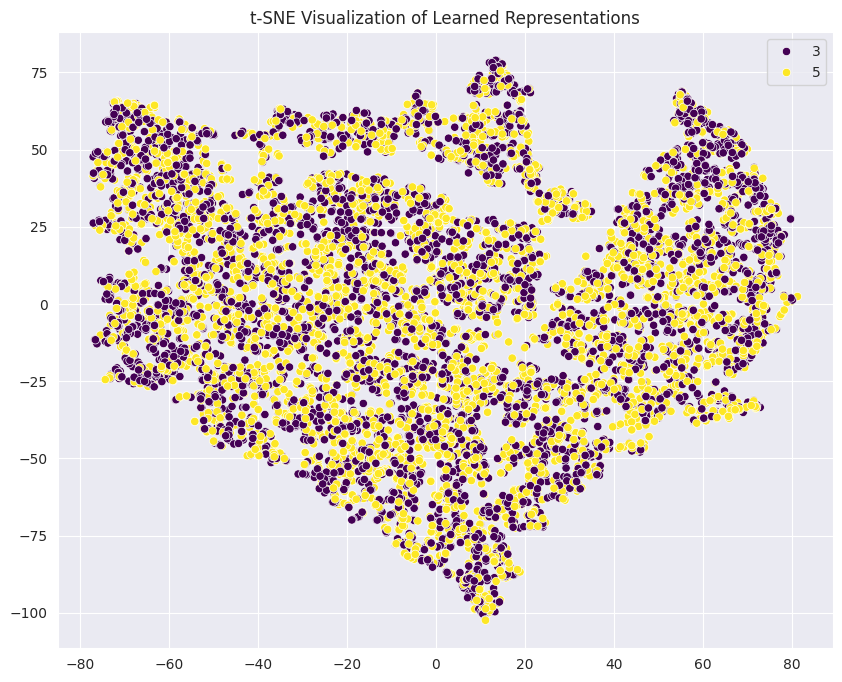

In [21]:
from sklearn.manifold import TSNE
import seaborn as sns


num_visualization_samples = 100
visualization_loader = DataLoader(subset_dataset, batch_size=num_visualization_samples, shuffle=True, num_workers=2)

model.eval()
all_features = []
all_labels = []

with torch.no_grad():
    for images, labels in visualization_loader:
        images = images.to(device)
        features = model.base_model(images)
        all_features.append(features.cpu().numpy())
        all_labels.append(labels.numpy())

all_features = np.concatenate(all_features, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
embedded_features = tsne.fit_transform(all_features)

# Plot the t-SNE embeddings
plt.figure(figsize=(10, 8))
sns.scatterplot(x=embedded_features[:, 0], y=embedded_features[:, 1], hue=all_labels, palette='viridis')
plt.title('t-SNE Visualization of Learned Representations')
plt.show()